<a href="https://colab.research.google.com/github/Flychuban/Plant_Leaf_Disease_Classification/blob/main/ClassificationModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32

In [7]:
# Load data
dataset = tf.keras.preprocessing.image_dataset_from_directory("/content/drive/MyDrive/PlantDiseaseClassification/data", shuffle=True, image_size=(IMAGE_SIZE, IMAGE_SIZE), batch_size=BATCH_SIZE)

Found 484 files belonging to 3 classes.


In [8]:
class_names = dataset.class_names

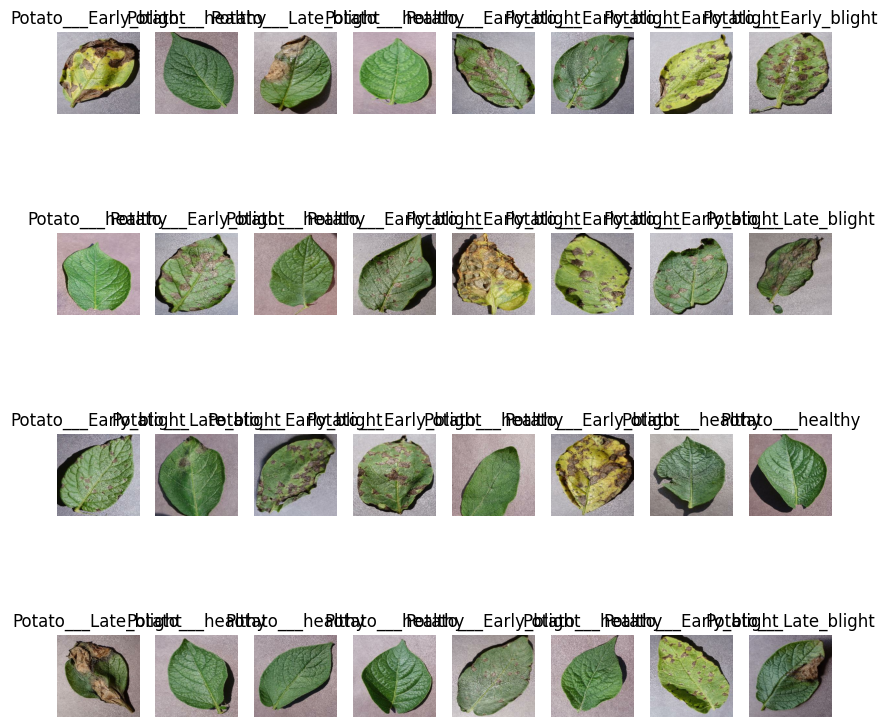

In [18]:
# Plot batch of images
for image_batch, label_batch in dataset.take(1):
  plt.figure(figsize=(10, 10))
  for i in range(BATCH_SIZE):
    ax = plt.subplot(4, 8, i+1)
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    plt.title(class_names[label_batch[i].numpy()])
    plt.axis('off')